# Import Libraries

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
style.use('dark_background')
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import LSTM, Embedding
from tensorflow.keras.models import Model

# Read the Data

In [10]:
df = pd.read_csv('spam.csv', encoding='ISO-8859-1')   # encoding='ISO-8859-1' encodes "Latin alphabet no. 1",
                                                      #consisting of 191 characters from the Latin script.

In [11]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [12]:
df.shape

(5572, 5)

# Drop Irrelevant Features

In [13]:
df = df.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)

In [14]:
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [15]:
df.shape

(5572, 2)

# Check for Null Values

In [16]:
df.isnull().any()

v1    False
v2    False
dtype: bool

# Rename the columns

In [17]:
df.columns = ['labels', 'Text']

In [18]:
df.head()

,labels,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


# Transform labels to integers

In [19]:
df['labels'] = df['labels'].map({'ham': 0, 'spam': 1})

In [20]:
df.head()

,labels,Text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [21]:
y = df['labels'].values
y.shape

(5572,)

In [22]:
y

array([0, 0, 1, ..., 0, 0, 0], dtype=int64)

# Perform data Splitting

In [23]:
X_train, X_test, y_train, y_test = train_test_split(df['Text'], y, test_size = 0.2, random_state = 42)

# Convert sentences to sequences

In [24]:
vocab_size = 20000
tokenizer = Tokenizer(num_words = vocab_size)
tokenizer.fit_on_texts(X_train)
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)

# Perform word to index mapping

In [25]:
word2idx = tokenizer.word_index
V = len(word2idx)
print('Found %s unique tokens.' % V)

Found 7954 unique tokens.


# Sequence padding to get N X T Matrix

In [26]:
trainX = pad_sequences(sequences_train)
print('Shape of train tensor:', trainX.shape)

Shape of train tensor: (4457, 121)


# Set seq_len OR timesteps

In [27]:
T = trainX.shape[1]
print(T)

121


# Padding Test data

In [28]:
testX = pad_sequences(sequences_test, maxlen=T)
print('Shape of test tensor:', testX.shape)

Shape of test tensor: (1115, 121)


# Create LSTM Model for Text Classification

In [29]:
D = 20  # Set the dimension of embeddings

H = 15 # Hidden state dimensions

i = Input(shape=(T, ))
x = Embedding(V + 1, D)(i) # This is N x T x D array. (V + 1) b/c we started from index 1
x = LSTM(H, return_sequences=True)(x)
print(x.shape)                       # N x T x H # Batchsize x steps x features
x = GlobalMaxPooling1D()(x)
print(" ")
print(x.shape)                       # N x H  # Batchsize x features
x = Dense(1, activation='sigmoid')(x)

model = Model(i, x)

(None, 121, 15)
 
(None, 15)


# Compile the Model

In [30]:
model.compile( loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'] )

# Train the Model

In [31]:
hist = model.fit(
  trainX,
  y_train,
  epochs=10,
  validation_data=(testX, y_test)
)

Epoch 1/10
140/140 [==============================] - 7s 35ms/step - loss: 0.4650 - accuracy: 0.8654 - val_loss: 0.3847 - val_accuracy: 0.8655
Epoch 2/10
140/140 [==============================] - 5s 33ms/step - loss: 0.3467 - accuracy: 0.8661 - val_loss: 0.3199 - val_accuracy: 0.8655
Epoch 3/10
140/140 [==============================] - 5s 33ms/step - loss: 0.2590 - accuracy: 0.8661 - val_loss: 0.2392 - val_accuracy: 0.8655
Epoch 4/10
140/140 [==============================] - 4s 32ms/step - loss: 0.1779 - accuracy: 0.9020 - val_loss: 0.1803 - val_accuracy: 0.9659
Epoch 5/10
140/140 [==============================] - 5s 32ms/step - loss: 0.1196 - accuracy: 0.9836 - val_loss: 0.1482 - val_accuracy: 0.9695
Epoch 6/10
140/140 [==============================] - 4s 32ms/step - loss: 0.0768 - accuracy: 0.9901 - val_loss: 0.1185 - val_accuracy: 0.9740
Epoch 7/10
140/140 [==============================] - 4s 32ms/step - loss: 0.0484 - accuracy: 0.9944 - val_loss: 0.1102 - val_accuracy: 0.9722

# Visualizing the Performance of Model

In [32]:
trainAcc = [100 * x for x in hist.history['accuracy']]
testAcc = [100 * x for x in hist.history['val_accuracy']]

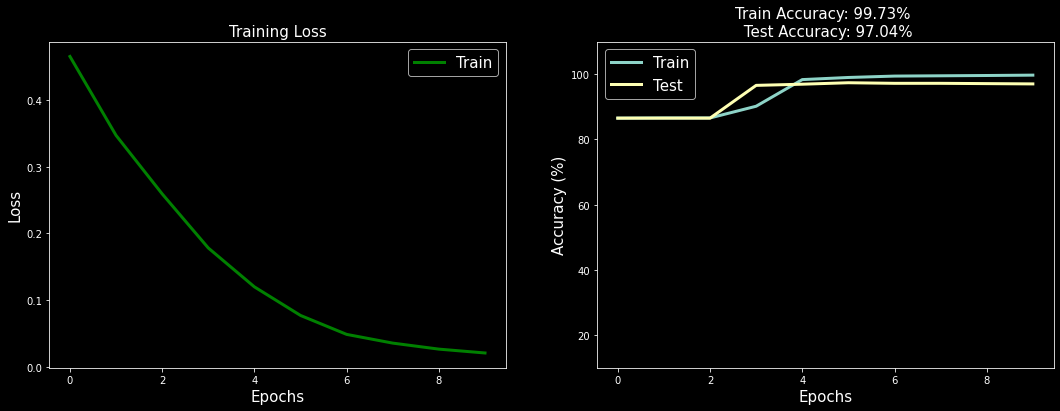

In [33]:
fig,ax = plt.subplots(1,2,figsize=(18,6))

ax[0].plot(hist.history['loss'], 'g', lw = 3, label = 'Train')
ax[0].set_xlabel('Epochs', fontsize = 15)
ax[0].set_ylabel('Loss', fontsize = 15)
ax[0].legend(fontsize = 15)
ax[0].set_title('Training Loss', fontsize = 15)


ax[1].plot(trainAcc, label ='Train', lw = 3)
ax[1].plot(testAcc, label ='Test', lw = 3)
ax[1].set_xlabel('Epochs', fontsize = 15)
ax[1].set_ylabel('Accuracy (%)', fontsize = 15)
ax[1].set_ylim([10,110])
ax[1].set_title(f'Train Accuracy: {trainAcc[-1]:.2f}% \n Test Accuracy: {testAcc[-1]:.2f}%', fontsize = 15)
ax[1].legend(fontsize = 15)

plt.show()

In [25]:
x = np.random.rand(2, 3, 4) # Batchsize x steps x features
y = GlobalMaxPooling1D()(x)
y.shape                     # Batchsize x features

TensorShape([2, 4])

In [8]:
for s in 'àáâãäåæçèéêëìíîï':
    i = ' '.join(['0x{:X}'.format(b) for b in s.encode('iso-8859-1')])
    print('%s | `%s`' % (s, i))

à | `0xE0`
á | `0xE1`
â | `0xE2`
ã | `0xE3`
ä | `0xE4`
å | `0xE5`
æ | `0xE6`
ç | `0xE7`
è | `0xE8`
é | `0xE9`
ê | `0xEA`
ë | `0xEB`
ì | `0xEC`
í | `0xED`
î | `0xEE`
ï | `0xEF`
